# **Clustering en un espacio de características**

Instalar tslearn

In [ ]:
!pip install tslearn
!pip install statsmodels
!pip install pmdarima

In [ ]:
!pip install scikit-optimize

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 2.7 MB/s eta 0:00:00


Importar librerías

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
from pmdarima.arima import auto_arima
from tslearn.utils import to_time_series_dataset
from sklearn.model_selection import train_test_split
from scipy.signal import butter, filtfilt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, precision_recall_fscore_support

Importar datos EEG de la base de datos Bonn University

In [ ]:
data = np.loadtxt("/content/bonn_dataset_columns_correct.csv", delimiter=",")[:, :].T
dataDF = pd.DataFrame(data)
X = to_time_series_dataset(data[:, 1:])
y = data[:, 0]

import numpy as np

# Cargar datos sin transponer
data = np.loadtxt("/content/bonn_dataset_columns_correct.csv", delimiter=",")
print("Forma de data sin transponer:", data.shape)

# Cargar datos con transposición
data_T = np.loadtxt("/content/bonn_dataset_columns_correct.csv", delimiter=",").T
print("Forma de data después de transponer:", data_T.shape)

Forma de data sin transponer: (4098, 500)
Forma de data después de transponer: (500, 4098)


División en daros de entrenamiento y prueba

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = X_train.squeeze(-1)  # Elimina la última dimensión
X_test = X_test.squeeze(-1)

Aplicación de un filtro de 40Hz

In [ ]:
def low_pass_filter(signal, cutoff=40.0, fs=173.61, order=5):
    nyquist = 0.5 * fs  # Frecuencia de Nyquist
    normal_cutoff = cutoff / nyquist  # Normalización de la frecuencia de corte
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, signal)  # Aplicar filtro

# Parámetros del filtro
cutoff_freq = 40.0  # Frecuencia de corte de 40 Hz
fs = 173.61  # Frecuencia de muestreo

# 📌 Filtrar señales EEG
X_train_filtered = np.array([low_pass_filter(signal, cutoff=cutoff_freq, fs=fs) for signal in X_train])
X_test_filtered = np.array([low_pass_filter(signal, cutoff=cutoff_freq, fs=fs) for signal in X_test])

Verificación de la forma de las señales

In [ ]:
print("Número de series temporales en el conjunto de entrenamiento:", X_train_filtered.shape[0])
print("Número de series temporales en el conjunto de prueba:", X_test_filtered.shape[0])
print("Longitud de las series temporales:", X_train_filtered.shape[1])

print("Forma de X_train antes del filtrado:", X_train.shape)
print("Forma de X_train_filtered después del filtrado:", X_train_filtered.shape)

Número de series temporales en el conjunto de entrenamiento: 400
Número de series temporales en el conjunto de prueba: 100
Longitud de las series temporales: 4097
Forma de X_train antes del filtrado: (400, 4097)
Forma de X_train_filtered después del filtrado: (400, 4097)


**Verificar estacionariedad de las señales**

Una serie de tiempo estacionaria tiene propiedades estadísticas que son constantes a lo largo del tiempo. Esto significa que las estadísticas como la media, la varianza y la autocorrelación no cambian a lo largo de los datos. La mayoría de los métodos estadísticos de previsión, incluido ARIMA, se basan en el supuesto de que las series temporales pueden hacerse aproximadamente estacionarias mediante una o varias transformaciones. Una serie estacionaria es comparativamente fácil de predecir porque se puede predecir simplemente que las propiedades estadísticas serán aproximadamente las mismas en el futuro que en el pasado.

Este paso es necesario porque ayuda a que el modelo se ajuste a los datos y no al ruido.

Estadístico ADF: -15.262972950477856
P-valor: 4.832248462041174e-28
✅ La serie es estacionaria
Estadístico ADF: -10.680164831147044
P-valor: 3.9591345398705337e-19
✅ La serie es estacionaria
Estadístico ADF: -9.902410816994756
P-valor: 3.3308366249113225e-17
✅ La serie es estacionaria
Estadístico ADF: -11.575107976919934
P-valor: 3.035958092609061e-21
✅ La serie es estacionaria
Estadístico ADF: -11.591351365248249
P-valor: 2.7869899311090596e-21
✅ La serie es estacionaria
Estadístico ADF: -9.212471204550754
P-valor: 1.871647176681266e-15
✅ La serie es estacionaria
Estadístico ADF: -11.068769186688757
P-valor: 4.609759755998072e-20
✅ La serie es estacionaria
Estadístico ADF: -16.150674668349755
P-valor: 4.5730810042039404e-29
✅ La serie es estacionaria
Estadístico ADF: -12.143568087323944
P-valor: 1.6300064348726692e-22
✅ La serie es estacionaria
Estadístico ADF: -10.480617865953883
P-valor: 1.2164360844881819e-18
✅ La serie es estacionaria
Estadístico ADF: -10.306540351884419
P-valor: 

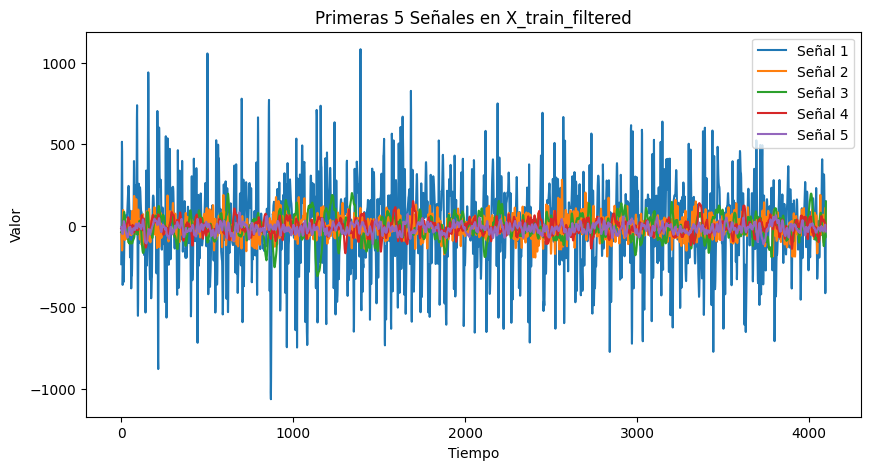

In [ ]:
def check_stationarity(signal):
    result = adfuller(signal)
    print(f"Estadístico ADF: {result[0]}")
    print(f"P-valor: {result[1]}")
    if result[1] < 0.05:
        print("✅ La serie es estacionaria")
    else:
        print("❌ La serie NO es estacionaria")

counter = 0
for signal in X_train_filtered:
    check_stationarity(signal)
    counter += 1

print("Señales: ", counter)

plt.figure(figsize=(10, 5))

for i, signal in enumerate(X_train_filtered[:5]):  # Solo las primeras 5 señales
    plt.plot(signal, label=f"Señal {i+1}")

plt.title("Primeras 5 Señales en X_train_filtered")
plt.xlabel("Tiempo")
plt.ylabel("Valor")
plt.legend()
plt.show()


# **ARIMA**

Prueba ACF y PACF

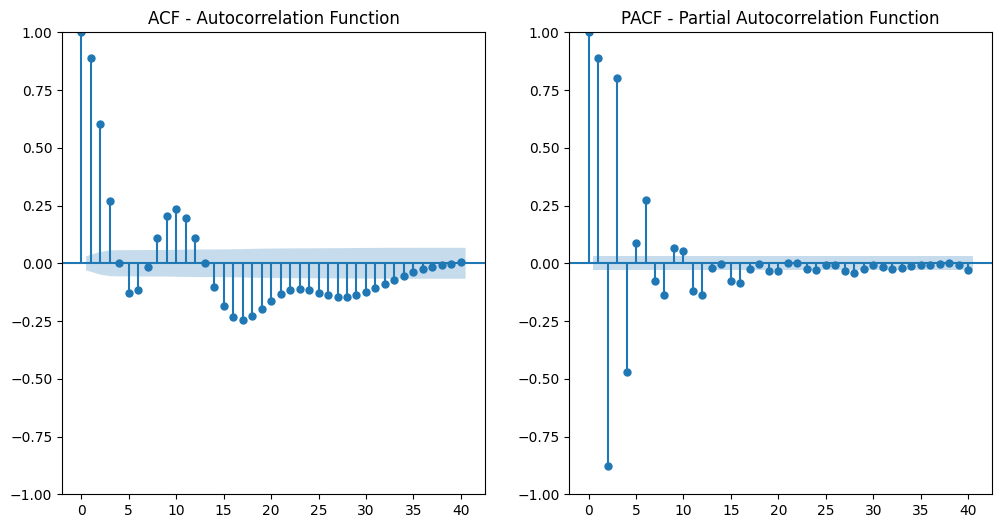

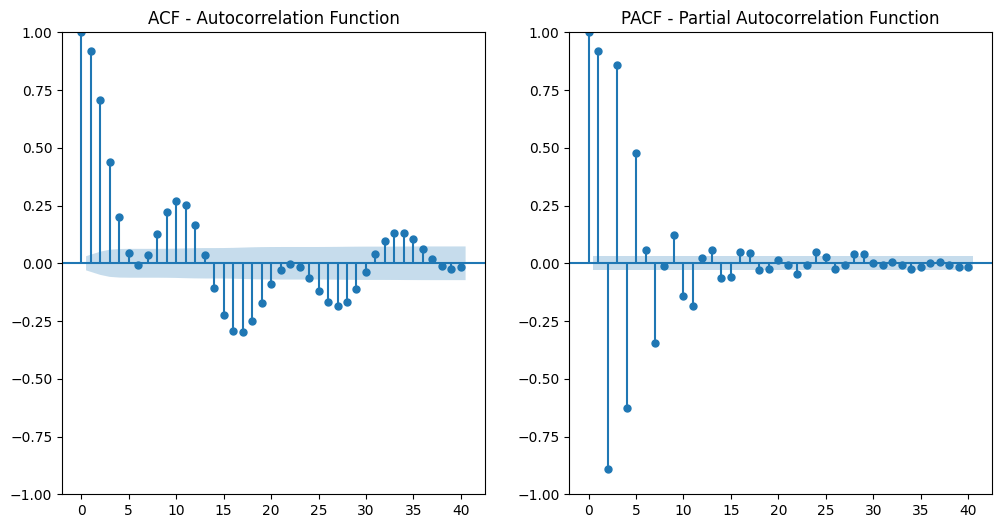

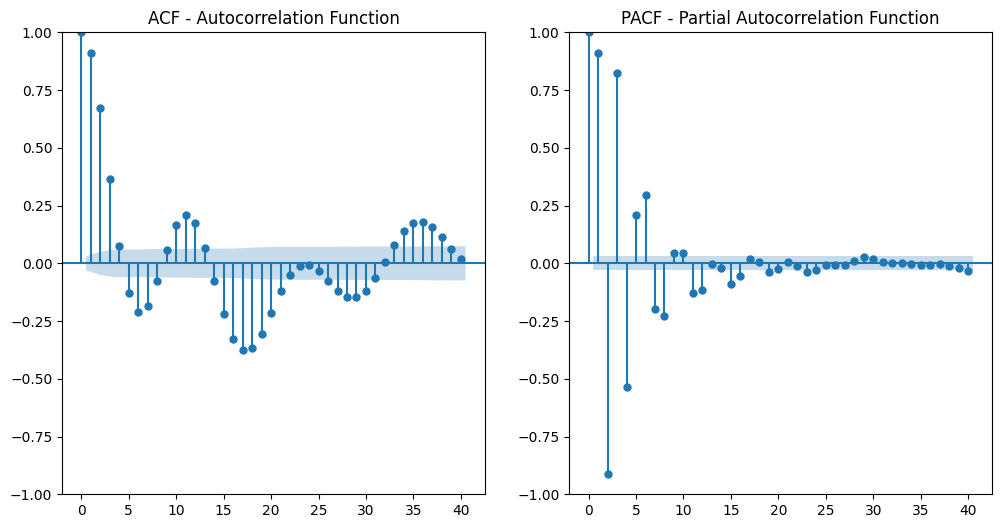

In [ ]:
# 📌 Determinar p y q usando ACF y PACF
def determine_arima_order(signal):
    plt.figure(figsize=(12, 6))

    plt.subplot(121)
    plot_acf(signal, lags=40, ax=plt.gca())
    plt.title("ACF - Autocorrelation Function")

    plt.subplot(122)
    plot_pacf(signal, lags=40, ax=plt.gca())
    plt.title("PACF - Partial Autocorrelation Function")

    plt.show()

    return


determine_arima_order(X_train_filtered[0])
determine_arima_order(X_train_filtered[160])
determine_arima_order(X_train_filtered[300])

In [ ]:
"""
order = (2, 0, 3)  # Parámetros del modelo ARIMA
n_forecast = 20  # Número de valores a predecir
predictions = []

for signal in X_train_filtered:
    model = ARIMA(signal, order=order)
    fitted_model = model.fit()
    forecast = fitted_model.forecast(steps=n_forecast)
    predictions.append(forecast)
    model_summary = fitted_model.summary()
    print(model_summary)

# 📌 Convertir predicciones en array NumPy
predictions_array = np.array(predictions)


# Evaluate model performance on the test set
#rmse = mean_squared_error(test_data["Price"], predictions, squared=False)
#print(f"RMSE: {rmse}")

n_forecast = 20  # Número de valores a predecir
predictions = []

for i, signal in enumerate(X_train_filtered):
    # 📌 Encontrar automáticamente los mejores (p, d, q)
    auto_model = auto_arima(signal, seasonal=False, stepwise=True, trace=True)
    best_order = auto_model.order  # Obtener los mejores parámetros

    # 📌 Ajustar modelo ARIMA con los mejores parámetros
    model = ARIMA(signal, order=best_order)
    fitted_model = model.fit()

    # 📌 Hacer predicción
    forecast = fitted_model.forecast(steps=n_forecast)
    predictions.append(forecast)

    # 📌 Mostrar resumen del modelo seleccionado
    print(f"\n🔹 Mejor modelo para señal {i+1}: ARIMA{best_order}")
    print(fitted_model.summary())

# 📌 Convertir predicciones en array NumPy
predictions_array = np.array(predictions)
"""


import statsmodels.api as sm
from mango import Tuner

# Definir la función para evaluar el modelo ARIMA
def evaluate_arima(params):
    p, d, q = params
    try:
        model = ARIMA(signal, order=(p, d, q))
        fitted_model = model.fit()
        aic = fitted_model.aic  # Se usa AIC como métrica de optimización
    except:
        aic = np.inf  # Penaliza configuraciones inválidas
    return aic

# Definir el espacio de búsqueda de hiperparámetros
param_space = {
    "p": range(0, 10),  # Rango para p
    "d": range(0, 3),  # Rango para d
    "q": range(0, 10)   # Rango para q
}

n_forecast = 20  # Número de valores a predecir
predictions = []
optimized_orders = {}

# Optimizar ARIMA para cada señal en X_train_filtered
for i, signal in enumerate(X_train_filtered):
    print(f"\nOptimizando ARIMA para la señal {i+1}...")

    # Ejecutar la optimización de hiperparámetros con Mango
    tuner = Tuner(param_space, evaluate_arima, num_iteration=20)
    opt_params, opt_value = tuner.minimize()

    # Guardar el mejor (p, d, q) encontrado
    optimized_orders[i] = opt_params
    print(f"Mejores parámetros encontrados para señal {i+1}: {opt_params} con AIC {opt_value}")

    # Entrenar modelo ARIMA con los mejores parámetros
    best_order = (opt_params["p"], opt_params["d"], opt_params["q"])
    model = ARIMA(signal, order=best_order)
    fitted_model = model.fit()

    # Generar pronóstico
    forecast = fitted_model.forecast(steps=n_forecast)
    predictions.append(forecast)

    # Mostrar resumen del modelo
    print(fitted_model.summary())

print("\nOptimización y predicción completadas.")


ImportError: cannot import name 'Tuner' from 'mango' (/usr/local/lib/python3.11/dist-packages/mango/__init__.py)

In [ ]:

fitted_model
forecast
predictions

In [ ]:
num_clusters = 5 # Número de clusters deseados
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(predictions_array)

# 📌 Crear un DataFrame con los clusters asignados
df_clusters = pd.DataFrame({
    "Señal": np.arange(len(X_train_filtered)),
    "Cluster": clusters
})

# 📊 Visualizar los clusters con un gráfico de dispersión
plt.figure(figsize=(10, 5))
sns.scatterplot(x=df_clusters["Señal"], y=df_clusters["Cluster"], hue=df_clusters["Cluster"], palette="viridis", s=100)
plt.xlabel("Señal EEG")
plt.ylabel("Cluster")
plt.title("Agrupación de señales EEG según predicciones ARIMA")
plt.legend(title="Cluster")
plt.show()

# 📊 Mostrar las señales agrupadas por cluster
for c in range(num_clusters):
    plt.figure(figsize=(10, 4))
    for i in range(len(X_train_filtered)):
        if clusters[i] == c:
            plt.plot(X_train_filtered[i], alpha=0.7, label=f"Señal {i}")

    plt.title(f"Señales EEG en Cluster {c}")
    plt.xlabel("Tiempo")
    plt.ylabel("Amplitud EEG")
    plt.legend()
    plt.show()